# Bayesian Optimization Pythia Tune using Ax - Reduced Parameters with Custom GP
> Created: June 9 2024 AAK, Harrison B. Prosper

## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser

----

This notebook is an extension for `BO_TuneAx_all_params.ipynb` and it performs Bayesian Optimizaion using [Ax](https://github.com/facebook/Ax) of the Lund string model parameters $a$ and $b$ that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{(1-z)^a}{z} \exp \left(-\frac{b m_{\perp}^2}{z}\right)
$$

which are referred to as `StringZ:aLund` and `StringZ:bLund` in pythia8, respectively.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

## Diferences from the previous notebook
This notebook differs from the previous notebook, `BO_TuneAx_all_params.ipynb`, in the following ways:

1. Instead of using the following test statistic:

$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2}, \tag{1}
$$


we will use a linear sum of $\chi^2$ variates:
$$
    \lambda(X; \theta) = \sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2, \tag{2}
$$

where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

The reason is that the peculiar objective function in Eq. (1) is designed for use in a neural network, so we cannot correctly interpret the minos errors as confidence intervals because the objective function doesn't have a $\chi^2$ distribution. On the other hand using Eq. (2) we can interpret this as a $\chi^2$ function for which the usual rules can be applied to derive the errors.


2. We keep fixed all the parameters which are not well determined to the values we found in `BO_TuneAx_all_params.ipynb`. We keep the parameters which are well-determined floating.

Well-determined parameters: [sigma, aExtraSQuark, enhancedFraction, probStoUD, probQQtoQ, probSQtoQQ, alphaSvalue, pTmin]

not well-determined parameters: [aLund, bLund, rFactC, rFactB, aExtraDiquark, enhancedWidth, ProbQQ1toQQ0]

In addition to floating the parameters which are well-determined, we also float $a$ and $b$ again. Therefore:

**floating parameters**: [ aLund, bLund, sigma, aExtraSQuark, enhancedFraction, probStoUD, probQQtoQ, probSQtoQQ, alphaSvalue, pTmin ]

**fixed parameters**: [rFactC, rFactB, aExtraDiquark, enhancedWidth, ProbQQ1toQQ0]

3. We remove histograms that have large discrepancies between theory and data in `BO_TuneAx_all_params.ipynb`, as these histograms could be causing biasing. These observables are just not well modeled by pythia. These observables (histograms) are: ['d35-x01-y01', 'd36-x01-y01','d39-x01-y01', 'd40-x01-y01']

----

## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

In [ ]:
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import importlib

from bayes_opt import BayesianOptimization, UtilityFunction 


from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.core.observation import ObservationFeatures


from typing import Optional

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from torch import Tensor


import torch
init_notebook_plotting()
# import plotly.io as pio
# pio.renderers.default = "jupyterlab"


#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

In [ ]:
BAYES_OPT=False
AX=True

In [ ]:
class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y, train_Yvar: Optional[Tensor] = None):
        # NOTE: This ignores train_Yvar and uses inferred noise instead.
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

Look at the commented optional things like acquisiion function

In [6]:
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate


ax_model = BoTorchModel(
    surrogate=Surrogate(
        # The model class to use
        botorch_model_class=SimpleCustomGP,
        # Optional, MLL class with which to optimize model parameters
        # mll_class=ExactMarginalLogLikelihood,
        # Optional, dictionary of keyword arguments to model constructor
        # model_options={}
    ),
    # Optional, acquisition function class to use - see custom acquisition tutorial
    # botorch_acqf_class=qExpectedImprovement,
)

In [7]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models


gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=5,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP),
            },
        ),
    ]
)

In [8]:
N_ITER = 120
best_param_filename_120 = f"best_parameters/all_parameters_Niter_{N_ITER}.csv"
best_parameters_120 = pd.read_csv(best_param_filename_120)
best_parameters_120

Unnamed: 0    aLund     bLund   rFactC    rFactB  aExtraSQuark  \
0           0  0.75248  1.049841  1.38034  0.819206           0.0   

   aExtraDiquark     sigma  enhancedFraction  enhancedWidth  ProbStoUD  \
0       0.931775  0.316637               0.0       1.939937   0.217093   

   probQQtoQ  probSQtoQQ  ProbQQ1toQQ0  alphaSvalue     pTmin  
0   0.104321    0.949422      0.164353      0.13793  0.495941

In [10]:
# FLOATING PARAAMS: 
# aLund, 
# bLund, 
# sigma, 
# aExtraSQuark, 
# enhancedFraction, 
# probStoUD, 
# probQQtoQ, 
# probSQtoQQ, 
# alphaSvalue, 
# pTmin

def make_pythia_card(aLund, 
                     bLund,
                    aExtraSQuark,
                    sigma,
                    enhancedFraction,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    alphaSvalue,
                    pTmin):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 250000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        f.write(f"StringZ:rFactC = {float(best_parameters_120['rFactC'])}\n\n")
        f.write(f"StringZ:rFactB = {float(best_parameters_120['rFactB'])}\n\n")
        f.write(f"StringZ:aExtraSQuark = {aExtraSQuark}\n\n")
        f.write(f"StringZ:aExtraDiquark = {float(best_parameters_120['aExtraDiquark'])}\n\n")
        f.write(f"StringPT:sigma = {sigma}\n\n")
        f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        f.write(f"StringPT:enhancedWidth = {float(best_parameters_120['enhancedWidth'])}\n\n")
        f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        f.write(f"StringFlav:ProbQQ1toQQ0 = {float(best_parameters_120['ProbQQ1toQQ0'])}\n\n")
        f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [11]:
dfdata, dfsims, generated_indices = get_data()
print('DATA DATAFRAME')
print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
print('FIRST SIM DATAFRAME')
print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

data_keys, mc_keys = get_hist_names(dfdata)

filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

print(f'length of filtered_data_keys = {len(filtered_data_keys)}')

[0, 0]
looping over 2 sim yoda files...



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1/2 [00:00<00:00,  6.70it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.83it/s]


using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.244000  0.009795  0.041595  0.031023     15305.0
1  0.005  0.010  23.642401  0.018914  0.177281  0.275517     29553.0
2  0.010  0.015  20.948799  0.016759  0.260082  0.654491     26186.0
3  0.015  0.020  16.832001  0.013466  0.293471  1.030342     21040.0
4  0.020  0.025  13.687200  0.010950  0.306621  1.379511     17109.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

In [12]:
def reduce_filtered_keys(filtered_data_keys, filtered_mc_keys):
    # Initialize empty list for the reduced keys
    reduced_data_keys = []
    reduced_mc_keys = []
    # List of histogram keys that need to be removed
    hists_to_remove = ['d35-x01-y01', 'd36-x01-y01', 'd39-x01-y01', 'd40-x01-y01']
    
    # Iterate over each data key
    for data_key in filtered_data_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(data_key) for hist_to_remove in hists_to_remove):
            reduced_data_keys.append(data_key)

    for mc_key in filtered_mc_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(mc_key) for hist_to_remove in hists_to_remove):
            reduced_mc_keys.append(mc_key)
            
        
    return reduced_data_keys, reduced_mc_keys

        

In [13]:
reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)
print(reduced_data_keys, reduced_mc_keys)
print(f'length of reduced data keys = {len(reduced_data_keys)}')
print(f'length of reduced mc keys = {len(reduced_mc_keys)}')

['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S3486095/d37-x01-y01',

In [14]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import *

def true_objective_func(aLund, 
                     bLund,
                    aExtraSQuark,
                    sigma,
                    enhancedFraction,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    alphaSvalue,
                    pTmin):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                     bLund,
                    aExtraSQuark,
                    sigma,
                    enhancedFraction,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    alphaSvalue,
                    pTmin)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    /media/ali/DATA/TEMP/rm ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 4.5: take out bad histograms
    reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)

    
    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(reduced_data_keys,
                                         reduced_mc_keys, 
                                         dfdata, 
                                         dfsims[gen_ind], 
                                         which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
    if BAYES_OPT:        
        objective_func = - X0[0]
    else:
        objective_func = X0[0]
    # os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

In [15]:
PARAM_DICT = {
        'StringZ:aLund' : [0.5, 2.0],
        'StringZ:bLund': [0.5, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,4.0],
        'StringFlav:ProbStoUD':[0,4.0],
        'StringFlav:probQQtoQ':[0,4.0],
        'StringFlav:probSQtoQQ':[0,4.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,4.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

REDUCED_MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "aExtraSQuark": 0.0,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

ab_tune_Monash_rest = REDUCED_MONASH_DICT.copy()
ab_tune_Monash_rest["aLund"] = 1.1279257649367096
ab_tune_Monash_rest["bLund"] =1.349756967243872
ab_tune_Monash_rest

{'aLund': 1.1279257649367096,
 'bLund': 1.349756967243872,
 'aExtraSQuark': 0.0,
 'sigma': 0.335,
 'enhancedFraction': 0.01,
 'ProbStoUD': 0.217,
 'probQQtoQ': 0.081,
 'probSQtoQQ': 0.915,
 'alphaSvalue': 0.1365,
 'pTmin': 0.5}

In [16]:
ax_client = AxClient(generation_strategy=gs)
ax_client.create_experiment(
name="Ax_Tune_Pythia",
        parameters = [
                    {
                        "name": "aLund",
                        "type": "range",
                        "bounds": [0.5, 2.0],
                    }, 
                    {
                        "name": "bLund",
                        "type": "range",
                        "bounds": [0.5, 2.0],
                    },

                    {
                        "name": "aExtraSQuark",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 

                    {
                        "name": "sigma",
                        "type": "range",
                        "bounds": [0.,1.],
                    }, 
                    {
                        "name": "enhancedFraction",
                        "type": "range",
                        "bounds": [0.,1.],
                    }, 

                    {
                        "name": "ProbStoUD",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "probQQtoQ",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "probSQtoQQ",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
   
                    {
                        "name": "alphaSvalue",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.06,0.25],
                    }, 
                    {
                        "name": "pTmin",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.1,2.0],
                    }, 
            
                ],
objectives = {"true_objective_func": ObjectiveProperties(minimize=True)},
)

[INFO 06-09 19:16:38] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 06-09 19:16:38] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter aLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-09 19:16:38] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-09 19:16:38] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter aExtraSQuark. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-09 19:16

In [ ]:


##########################################
# Sample Monash Tune point
suggest_param, suggest_ind = ax_client.attach_trial(
    parameters=REDUCED_MONASH_DICT
)
ax_client.complete_trial(trial_index=suggest_ind, raw_data=true_objective_func(
        aLund=suggest_param["aLund"], 
        bLund=suggest_param["bLund"],
        aExtraSQuark=suggest_param["aExtraSQuark"],
        sigma=suggest_param["sigma"],
        enhancedFraction=suggest_param["enhancedFraction"],
        ProbStoUD=suggest_param["ProbStoUD"],
        probQQtoQ=suggest_param["probQQtoQ"],
        probSQtoQQ=suggest_param["probSQtoQQ"],
        alphaSvalue=suggest_param["alphaSvalue"],
        pTmin=suggest_param["pTmin"]
))
##########################################
# Sample ab tune point with the rest of the parameters from the Monash tune
suggest_param_ab, suggest_ind_ab = ax_client.attach_trial(
    parameters=ab_tune_Monash_rest
)
ax_client.complete_trial(trial_index=suggest_ind_ab, raw_data=true_objective_func(
        aLund=suggest_param_ab["aLund"], 
        bLund=suggest_param_ab["bLund"],
        aExtraSQuark=suggest_param_ab["aExtraSQuark"],
        sigma=suggest_param_ab["sigma"],
        enhancedFraction=suggest_param_ab["enhancedFraction"],
        ProbStoUD=suggest_param_ab["ProbStoUD"],
        probQQtoQ=suggest_param_ab["probQQtoQ"],
        probSQtoQQ=suggest_param_ab["probSQtoQQ"],
        alphaSvalue=suggest_param_ab["alphaSvalue"],
        pTmin=suggest_param_ab["pTmin"]
))


##########################################
# start main tuning loop
N_ITER = 100
for i in range(N_ITER):
    parameterization, trial_index = ax_client.get_next_trial()
    print(parameterization)
    ax_client.complete_trial(trial_index=trial_index, raw_data=true_objective_func(
        aLund=parameterization["aLund"], 
        bLund=parameterization["bLund"],
        aExtraSQuark=parameterization["aExtraSQuark"],
        sigma=parameterization["sigma"],
        enhancedFraction=parameterization["enhancedFraction"],
        ProbStoUD=parameterization["ProbStoUD"],
        probQQtoQ=parameterization["probQQtoQ"],
        probSQtoQQ=parameterization["probSQtoQQ"],
        alphaSvalue=parameterization["alphaSvalue"],
        pTmin=parameterization["pTmin"]
    ))



[INFO 06-09 19:17:10] ax.core.experiment: Attached custom parameterizations [{'aLund': 0.68, 'bLund': 0.98, 'aExtraSQuark': 0.0, 'sigma': 0.335, 'enhancedFraction': 0.01, 'ProbStoUD': 0.217, 'probQQtoQ': 0.081, 'probSQtoQQ': 0.915, 'alphaSvalue': 0.1365, 'pTmin': 0.5}] as trial 0.
/tmp/ipykernel_19521/4242634014.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_19521/4242634014.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_19521/4242634014.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_19521/4242634014.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda



[INFO 06-09 19:17:28] ax.service.ax_client: Completed trial 0 with data: {'true_objective_func': (6428.246051, None)}.
[INFO 06-09 19:17:28] ax.core.experiment: Attached custom parameterizations [{'aLund': 1.127926, 'bLund': 1.349757, 'aExtraSQuark': 0.0, 'sigma': 0.335, 'enhancedFraction': 0.01, 'ProbStoUD': 0.217, 'probQQtoQ': 0.081, 'probSQtoQQ': 0.915, 'alphaSvalue': 0.1365, 'pTmin': 0.5}] as trial 1.


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.244000  0.009795  0.041595  0.031023     15305.0
1  0.005  0.010  23.642401  0.018914  0.177281  0.275517     29553.0
2  0.010  0.015  20.948799  0.016759  0.260082  0.654491     26186.0
3  0.015  0.020  16.832001  0.013466  0.293471  1.030342     21040.0
4  0.020  0.025  13.687200  0.010950  0.306621  1.379511     17109.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01

/tmp/ipykernel_19521/4242634014.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_19521/4242634014.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_19521/4242634014.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_19521/4242634014.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_19521/4242634014.py:58: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead




 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

In [187]:
best_parameters_reduced, values = ax_client.get_best_parameters()
print("BEST PARAMETERS: ", best_parameters_reduced)
best_parameters_df = pd.DataFrame(best_parameters_reduced, index=[0])
best_param_filename = f"best_parameters/reduced_parameters_Niter_{N_ITER}.csv"
best_parameters_df.to_csv(best_param_filename)
# best_parameters = pd.read_csv(best_param_filename)

BEST PARAMETERS:  {'aLund': 0.6500049858724484, 'bLund': 0.9401929253219509, 'aExtraSQuark': 0.9168928775652091, 'sigma': 0.30812601635724085, 'enhancedFraction': 0.09376606126317734, 'ProbStoUD': 0.22732590820741946, 'probQQtoQ': 0.09828054814612876, 'probSQtoQQ': 2.0547395267064457, 'alphaSvalue': 0.135045793331446, 'pTmin': 0.3779248422937622}


In [188]:
model = ax_client.generation_strategy.model
df = ax_client.get_trials_data_frame()
df

[WARNING 06-06 15:31:22] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


trial_index arm_name trial_status generation_method  true_objective_func  \
0              0      0_0    COMPLETED            Manual          6733.075946   
1              1      1_0    COMPLETED            Manual          6764.128706   
2              2      2_0    COMPLETED             Sobol        846108.081834   
3              3      3_0    COMPLETED             Sobol        776542.922997   
4              4      4_0    COMPLETED             Sobol        886515.342325   
..           ...      ...          ...               ...                  ...   
97            97     97_0    COMPLETED           BoTorch          5346.564420   
98            98     98_0    COMPLETED           BoTorch          5037.861588   
99            99     99_0    COMPLETED           BoTorch          7753.419010   
100          100    100_0    COMPLETED           BoTorch          5888.759638   
101          101    101_0    COMPLETED           BoTorch          6428.246051   

        aLund     bLund  aExtraSQuark     sigma  enhancedFraction  ProbStoUD  \
0    0.680000  0.980000      0.000000  0.335000          0.010000   0.217000   
1    1.127926  1.349757      0.000000  0.335000          0.010000   0.217000   
2    1.023334  0.965479      0.033352  0.766123          0.916146   2.476770   
3    1.685088  0.954130      1.918309  0.836876          0.305434   3.783173   
4    1.233700  1.693517      0.643285  0.472614          0.424180   2.071608   
..        ...       ...           ...       ...               ...        ...   
97   1.044490  1.324818      0.823975  0.302547          0.148204   0.205876   
98   0.650005  0.940193      0.916893  0.308126          0.093766   0.227326   
99   0.935020  0.934524      1.082229  0.304283          0.124800   0.175033   
100  0.745718  1.120232      0.785379  0.295756          0.132544   0.251376   
101  0.500000  0.991862      0.598793  0.320314          0.052432   0.229819   

     probQQtoQ  probSQtoQQ  alphaSvalue     pTmin  
0     0.081000    0.915000     0.136500  0.500000  
1     0.081000    0.915000     0.136500  0.500000  
2     2.449059    0.441878     0.160037  1.869554  
3     2.135141    1.309074     0.146840  1.914191  
4     2.896339    3.193010     0.087882  0.820307  
..         ...         ...          ...       ...  
97    0.100871    1.621882     0.134653  0.325913  
98    0.098281    2.054740     0.135046  0.377925  
99    0.107401    2.216793     0.133561  0.325270  
100   0.085991    1.845201     0.133854  0.370213  
101   0.099978    1.643123     0.137019  0.418890  

[102 rows x 15 columns]

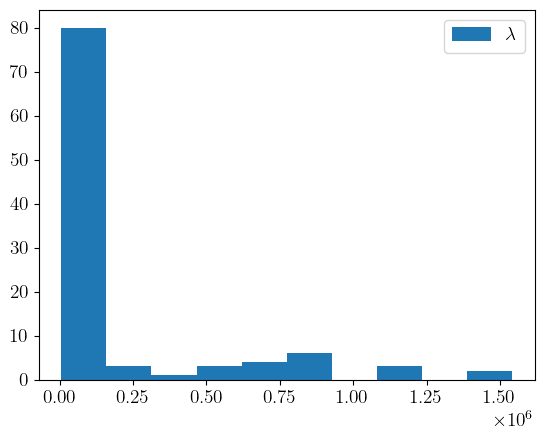

In [189]:
plt.hist(df['true_objective_func'], label='$\lambda$')
plt.legend()

In [190]:
param_names = list(PARAM_DICT.keys())
params = [param_name.split(':')[1] for param_name in param_names]
print(params)
print(len(params))

['aLund', 'bLund', 'aExtraSQuark', 'sigma', 'enhancedFraction', 'ProbStoUD', 'probQQtoQ', 'probSQtoQQ', 'alphaSvalue', 'pTmin']
10


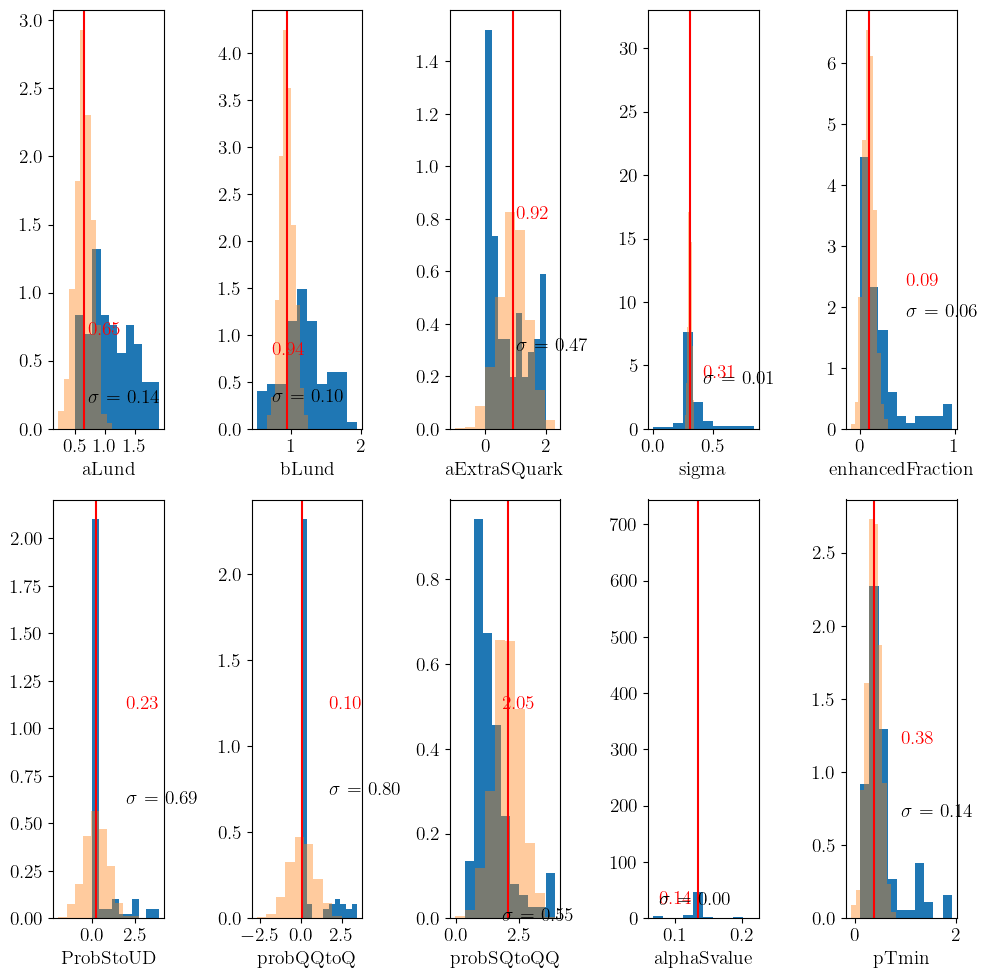

In [191]:
param_vals = [df[param] for param in params]
full_vals = np.stack(param_vals)
full_cov = np.cov(full_vals)

fig, ax = plt.subplots(2,5, figsize=(10,10))
ax = ax.ravel()
stds = np.diagonal(full_cov)
for i, param in enumerate(params):
    vals = df[param].values
    std2 = stds[i]
    ax[i].hist(vals, density=True)
    ax[i].set_xlabel(param)
    best_param = best_parameters_reduced[param]
    ax[i].axvline(x=best_param, color = 'r')
    x_pos = (vals.max() - vals.min())/2
    y_pos = (ax[i].get_ylim()[1] - ax[i].get_ylim()[0])/2
    ax[i].text(y=y_pos, x=x_pos, s=f'{best_param:.2f}', color='r')
    ax[i].text(y=y_pos - 0.5, x=x_pos, s=f'$\sigma$ = {std2:.2f}', color='k')
    gauss = np.random.normal(best_param, std2, size=1000)
    ax[i].hist(gauss, density=True, alpha=0.4)
plt.tight_layout()

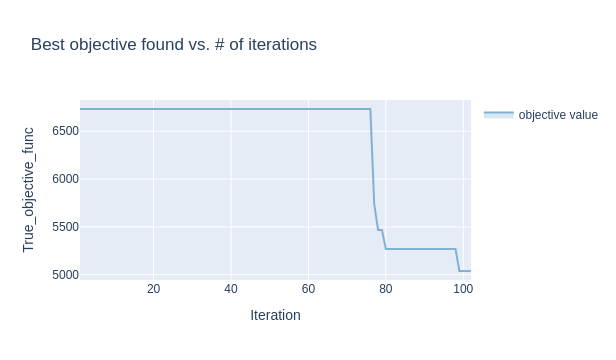

In [192]:
render(ax_client.get_optimization_trace())

[INFO 06-06 15:32:00] ax.service.ax_client: Retrieving contour plot with parameter 'aLund' on X-axis and 'bLund' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


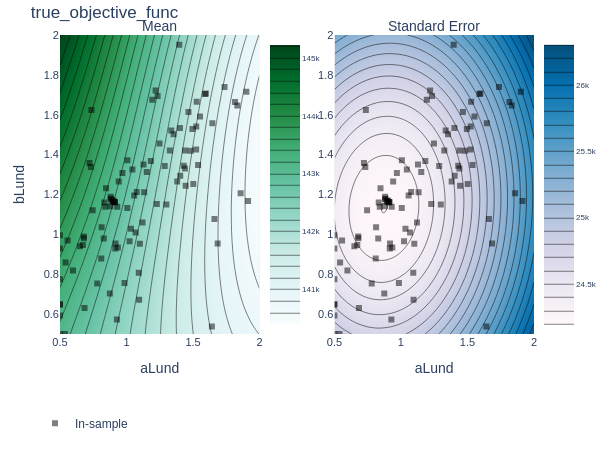

In [193]:
import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(
render(ax_client.get_contour_plot(param_x="aLund", param_y="bLund",))
# )


# fig.show()
# fig.write_image("images/Lund_a_b_countour.pdf")

[INFO 06-06 15:32:23] ax.service.ax_client: Retrieving contour plot with parameter 'aLund' on X-axis and 'sigma' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


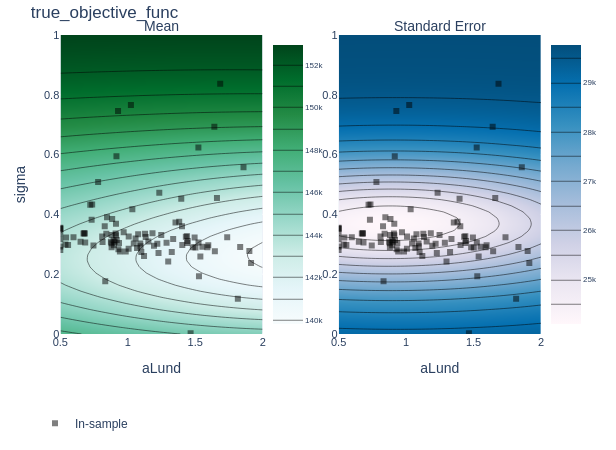

In [194]:
render(ax_client.get_contour_plot(param_x="aLund", param_y="sigma",))

[INFO 06-06 15:32:31] ax.service.ax_client: Retrieving contour plot with parameter 'aExtraSQuark' on X-axis and 'sigma' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


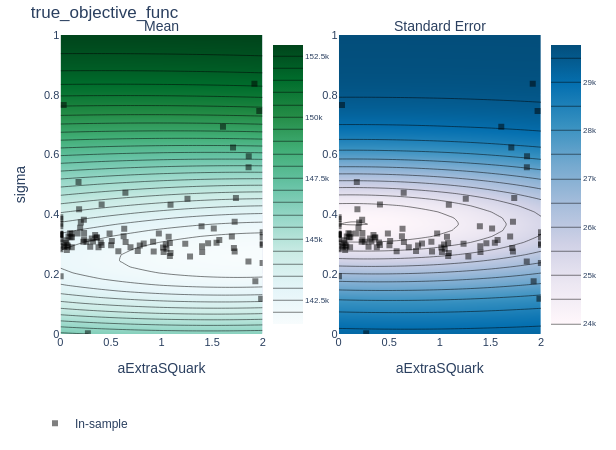

In [195]:
render(ax_client.get_contour_plot(param_x="aExtraSQuark", param_y="sigma",))

[INFO 06-06 15:33:01] ax.service.ax_client: Retrieving contour plot with parameter 'probQQtoQ' on X-axis and 'sigma' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


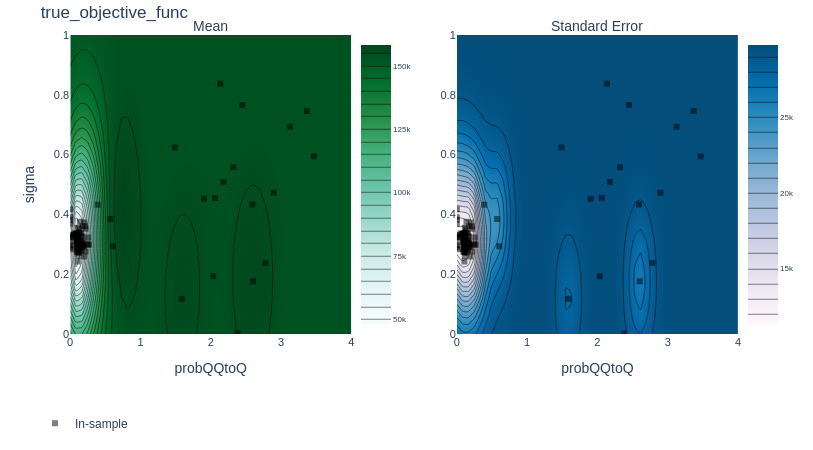

In [197]:
render(ax_client.get_contour_plot(param_x="probQQtoQ", param_y="sigma",))

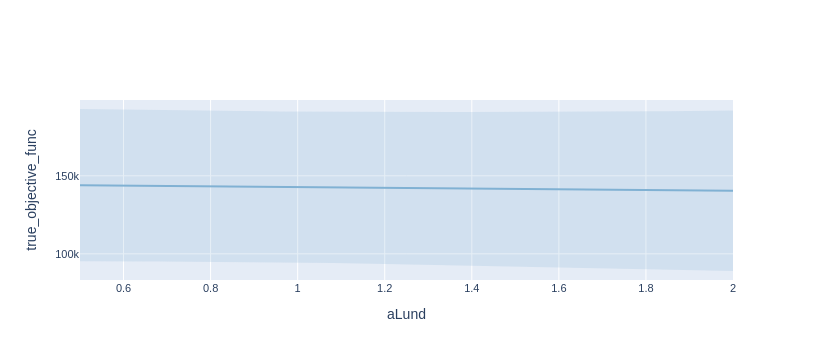

In [198]:
from ax.plot.slice import plot_slice

model = ax_client.generation_strategy.model
render(plot_slice(model, "aLund", "true_objective_func"))

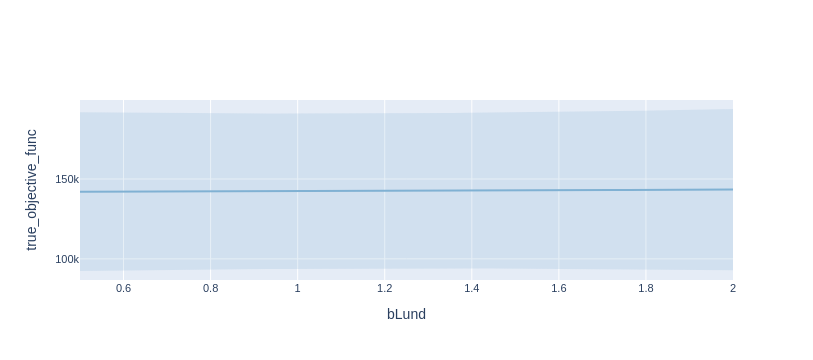

In [199]:
render(plot_slice(model, "bLund", "true_objective_func"))

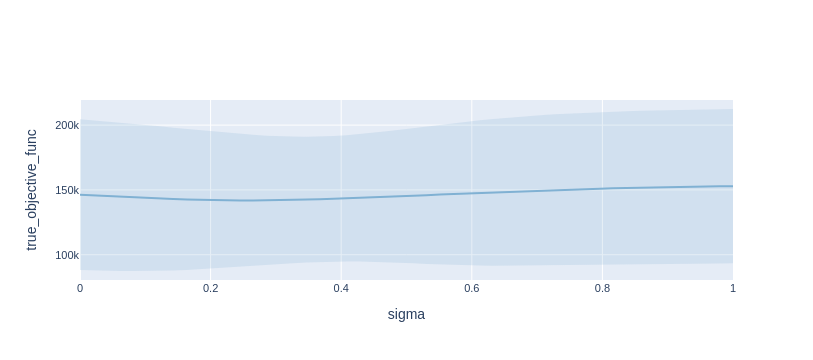

In [200]:
render(plot_slice(model, "sigma", "true_objective_func"))

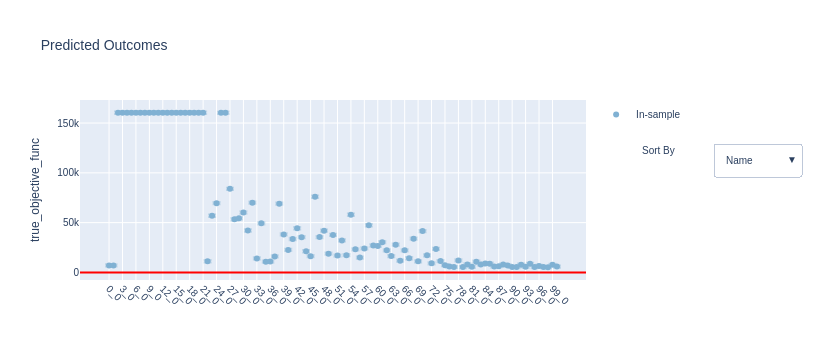

In [201]:
from ax.plot.scatter import plot_fitted
render(plot_fitted(model, metric="true_objective_func", rel=False))

In [202]:
ax_client.get_best_trial()

(101,
 {'aLund': 0.6500049858724484,
  'bLund': 0.9401929253219509,
  'aExtraSQuark': 0.9168928775652091,
  'sigma': 0.30812601635724085,
  'enhancedFraction': 0.09376606126317734,
  'ProbStoUD': 0.22732590820741946,
  'probQQtoQ': 0.09828054814612876,
  'probSQtoQQ': 2.0547395267064457,
  'alphaSvalue': 0.135045793331446,
  'pTmin': 0.3779248422937622},
 ({'true_objective_func': 5282.246758142166},
  {'true_objective_func': {'true_objective_func': 307167.44665173726}}))

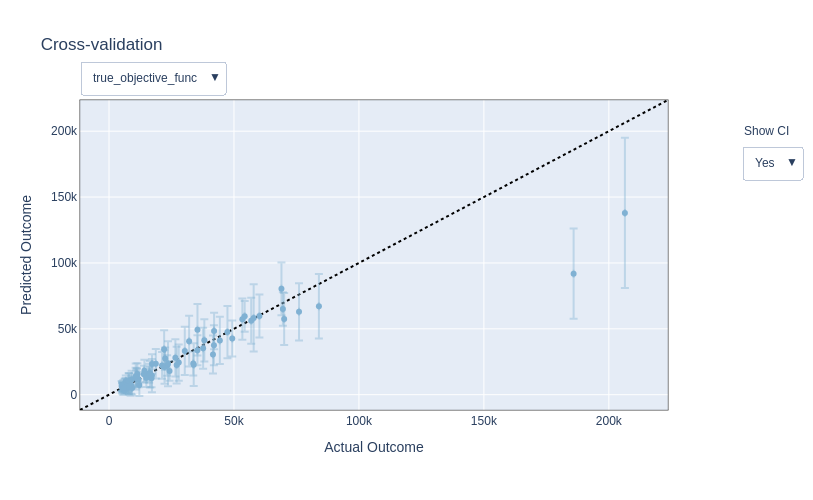

In [203]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation

cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

----

## Validate the results

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [204]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 250000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))
        # f.write("StringZ:rFactC = {}\n\n".format(best_parameters["rFactC"]))
        # f.write("StringZ:rFactB = {}\n\n".format(best_parameters["rFactB"]))
        f.write("StringZ:aExtraSQuark = {}\n\n".format(best_parameters["aExtraSQuark"]))
        # f.write("StringZ:aExtraDiquark = {}\n\n".format(best_parameters["aExtraDiquark"]))
        f.write("StringPT:sigma = {}\n\n".format(best_parameters["sigma"]))
        f.write("StringPT:enhancedFraction = {}\n\n".format(best_parameters["enhancedFraction"]))
        # f.write("StringPT:enhancedWidth = {}\n\n".format(best_parameters["enhancedWidth"]))
        f.write("StringFlav:ProbStoUD = {}\n\n".format(best_parameters["ProbStoUD"]))
        f.write("StringFlav:probQQtoQ = {}\n\n".format(best_parameters["probQQtoQ"]))
        f.write("StringFlav:probSQtoQQ = {}\n\n".format(best_parameters["probSQtoQQ"]))
        # f.write("StringFlav:ProbQQ1toQQ0 = {}\n\n".format(best_parameters["ProbQQ1toQQ0"]))
        f.write("TimeShower:alphaSvalue = {}\n\n".format(best_parameters["alphaSvalue"]))
        f.write("TimeShower:pTmin = {}\n\n".format(best_parameters["pTmin"]))
def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

In [205]:
run_valid_card(best_parameters_reduced)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-06 15:38:16
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:03 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:04 elapsed)
Event 2400 (0:00:04 elapsed)
Event 2500 (0:00:04 elapsed)
Event 2600 (0:00:04 elapsed)
Event 2700 (0:00:04 elapsed)
Event 2800 (0:00:04 elapsed)
Event 2900 (0:00:04 elapsed)
Event 3000 (0





Rivet.AnalysisHandler: INFO  Using named weights


In [206]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy

def get_valid_data():
    # tracemalloc.start()
    yoda2numpy = Yoda2Numpy()
    files = list(glob('ALEPH_YODAS_BayesOpt/*.yoda'))
    M = len(files)
    # M = 
    generated_indices = []
    for file in files[:M]:
        index = file.split('_')[-1].split('.')[0]
        generated_indices.append(int(index))    
    generated_indices.sort()
    print(generated_indices)
    # # --- SIM
    print(f'looping over {M:d} sim yoda files...\n')
    # dfsims = []
    dfsims_valid = {}
    for ii in tqdm(generated_indices):    
        # index here should match the index of the file
        # dfsims.append( yoda2numpy.todf( yoda2numpy('sim', index=ii) ) )
        dfsims_valid[ii]= yoda2numpy.todf( yoda2numpy('val', index=ii) ) 

    # # --- NEW
    # print(f'looping over {M:d} new yoda files...\n')
    # # dfnews = []
    # # for ii in tqdm(range(M)):
    # #     dfnews.append( yoda2numpy.todf( yoda2numpy('new', index=ii) ) )

    print()
    # key = '/ALEPH_1996_S3486095/d01-x01-y01'
    # dfsim = dfsims[0][key]
    
    dfdata = yoda2numpy.todf( yoda2numpy('dat') )
    
    return dfdata, dfsims_valid, generated_indices

In [207]:
dfdata, dfsims_valid, generated_indices = get_valid_data()

[0, 0]
looping over 2 sim yoda files...



  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


In [208]:
print(generated_indices)
# print(dfsims)
print('DATA DATAFRAME')
print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
print('FIRST SIM-VALID DATAFRAME')
print(dfsims_valid[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

[0, 0]
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM-VALID DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.676000  0.009341  0.040054  0.030145     14595.0
1  0.005  0.010  23.655199  0.018924  0.177620  0.276473     29569.0
2  0.010  0.015  21.341600  0.017073  0.265181  0.667883     26677.0
3  0.015  0.020  17.384800  0.013908  0.302801  1.062028     21731.0
4  0.020  0.025  13.728800  0.010983  0.307631  1.384390     17161.0


In [209]:
data_keys, mc_keys = get_hist_names(dfdata)
filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims_valid, data_keys, mc_keys)

 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

In [210]:
reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)
print(reduced_data_keys, reduced_mc_keys)
print(f'length of reduced data keys = {len(reduced_data_keys)}')
print(f'length of reduced mc keys = {len(reduced_mc_keys)}')

['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S3486095/d37-x01-y01',

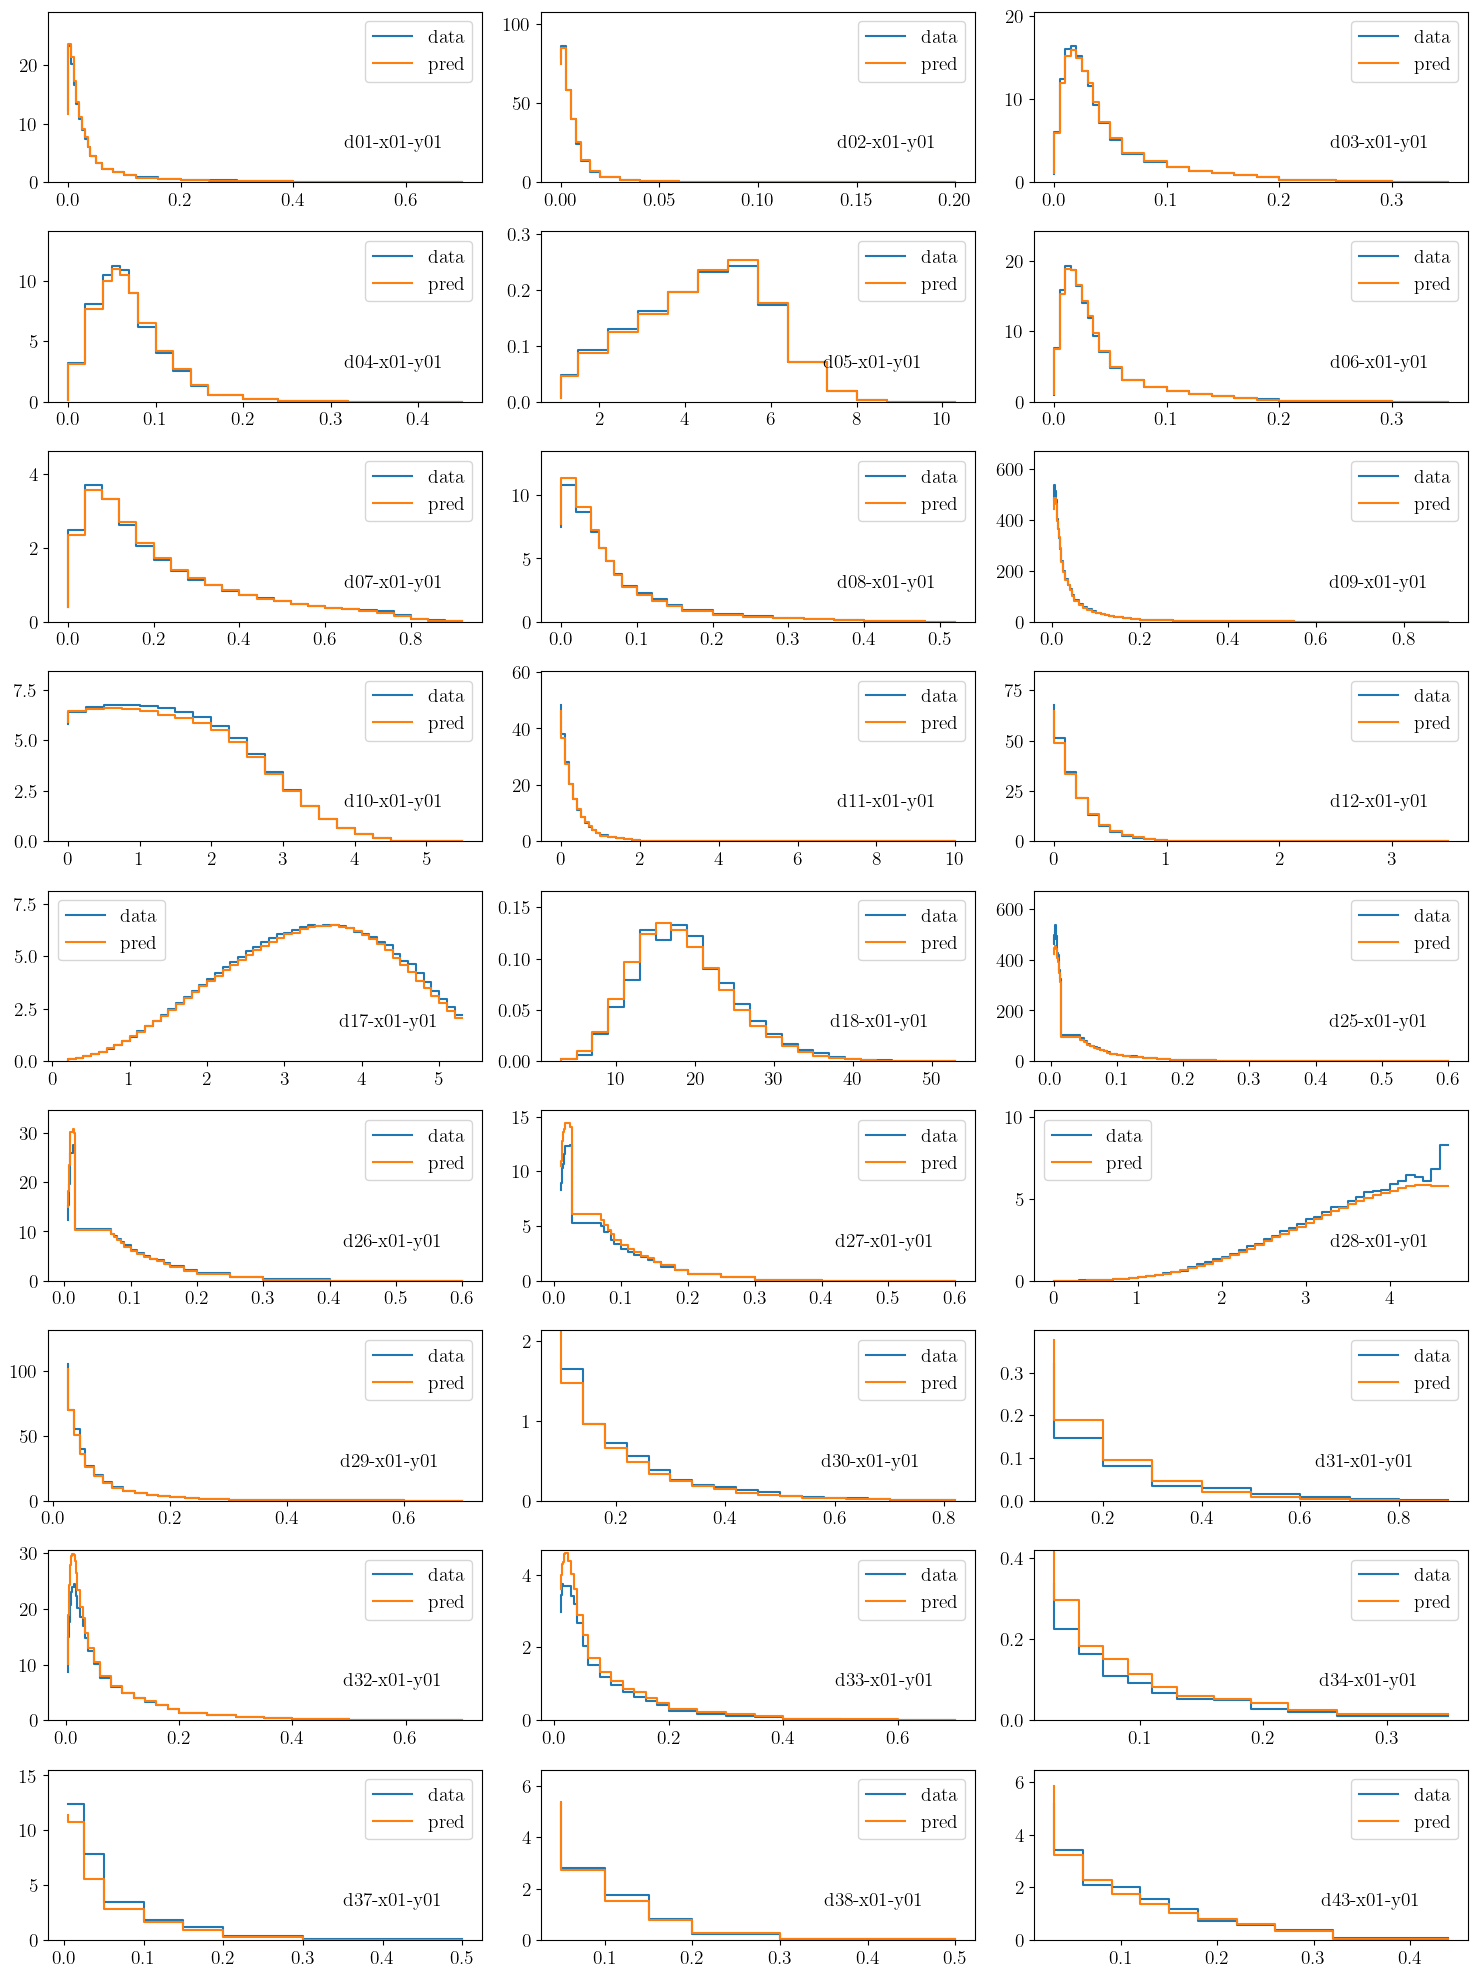

In [211]:
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import * 

hists = make_hists(dfdata, dfsims_valid[0], reduced_data_keys, reduced_mc_keys)

plot_dist(reduced_data_keys, hists, filename=f'images/Ax_BayesianOpt_Valid_Best_fit_hists_reduced_params_{N_ITER}_iter.pdf')

In [283]:
def plot_model_chi2_vs_param(param, reference_dict, ax):
    PARAM_DICT_small = {key.split(':')[1] : val for key,val in PARAM_DICT.items()}
    # param = 'aLund'
    N_points = 1000
    # reference_dict = MONASH_DICT
    param_linspace =  np.linspace(PARAM_DICT_small[param][0], PARAM_DICT_small[param][1], N_points)
    param_observation_dicts = []
    for val in param_linspace:
        new_dict = reference_dict.copy()
        new_dict[param] = val
        param_observation_dicts.append(new_dict)
    
    means_a, covs_a = model.predict([
            ObservationFeatures(parameters=pointi) for pointi in param_observation_dicts
        ]
    )

    chi2_means = np.array(list(means_a.values())[0])
    chi2_covs = np.sqrt(np.array(covs_a['true_objective_func']['true_objective_func']))
    
    ax.plot(aLund_linspace, chi2_means, c='k', linewidth=3)

    ax.set_ylim(0, chi2_means.max())
    ypos = (ax.get_ylim()[1] -ax.get_ylim()[0])/2
    xpos = best_parameters_reduced[param] + 0.05
    ax.text(x= xpos, y=ypos, s= '{:.3f}'.format(best_parameters_reduced[param]), color='r')
    ax.fill_between(x=aLund_linspace, y1=chi2_means-chi2_covs,y2=chi2_means+chi2_covs, alpha=0.3, color='b')
    ax.set_xlabel(param, fontsize=22)
    ax.set_ylabel('GP $\lambda$', fontsize=22)
    ax.scatter(df[param], df['true_objective_func'], color='green')
    ax.axvline(x=best_parameters_reduced[param], color='r')

NameError: name 'aLund_linspace' is not defined

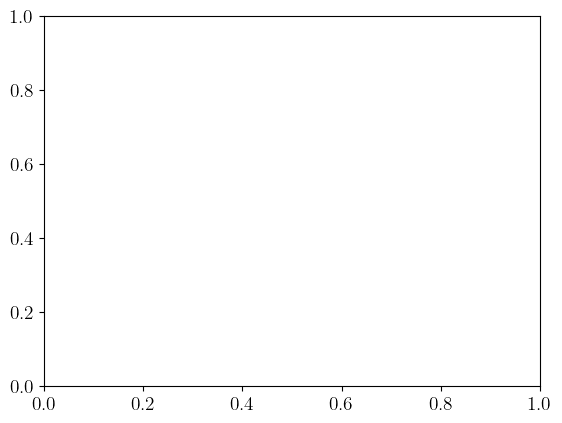

In [284]:
fig, ax = plt.subplots(1,1)
plot_model_chi2_vs_param(param='aLund', reference_dict=best_parameters_reduced, ax=ax)

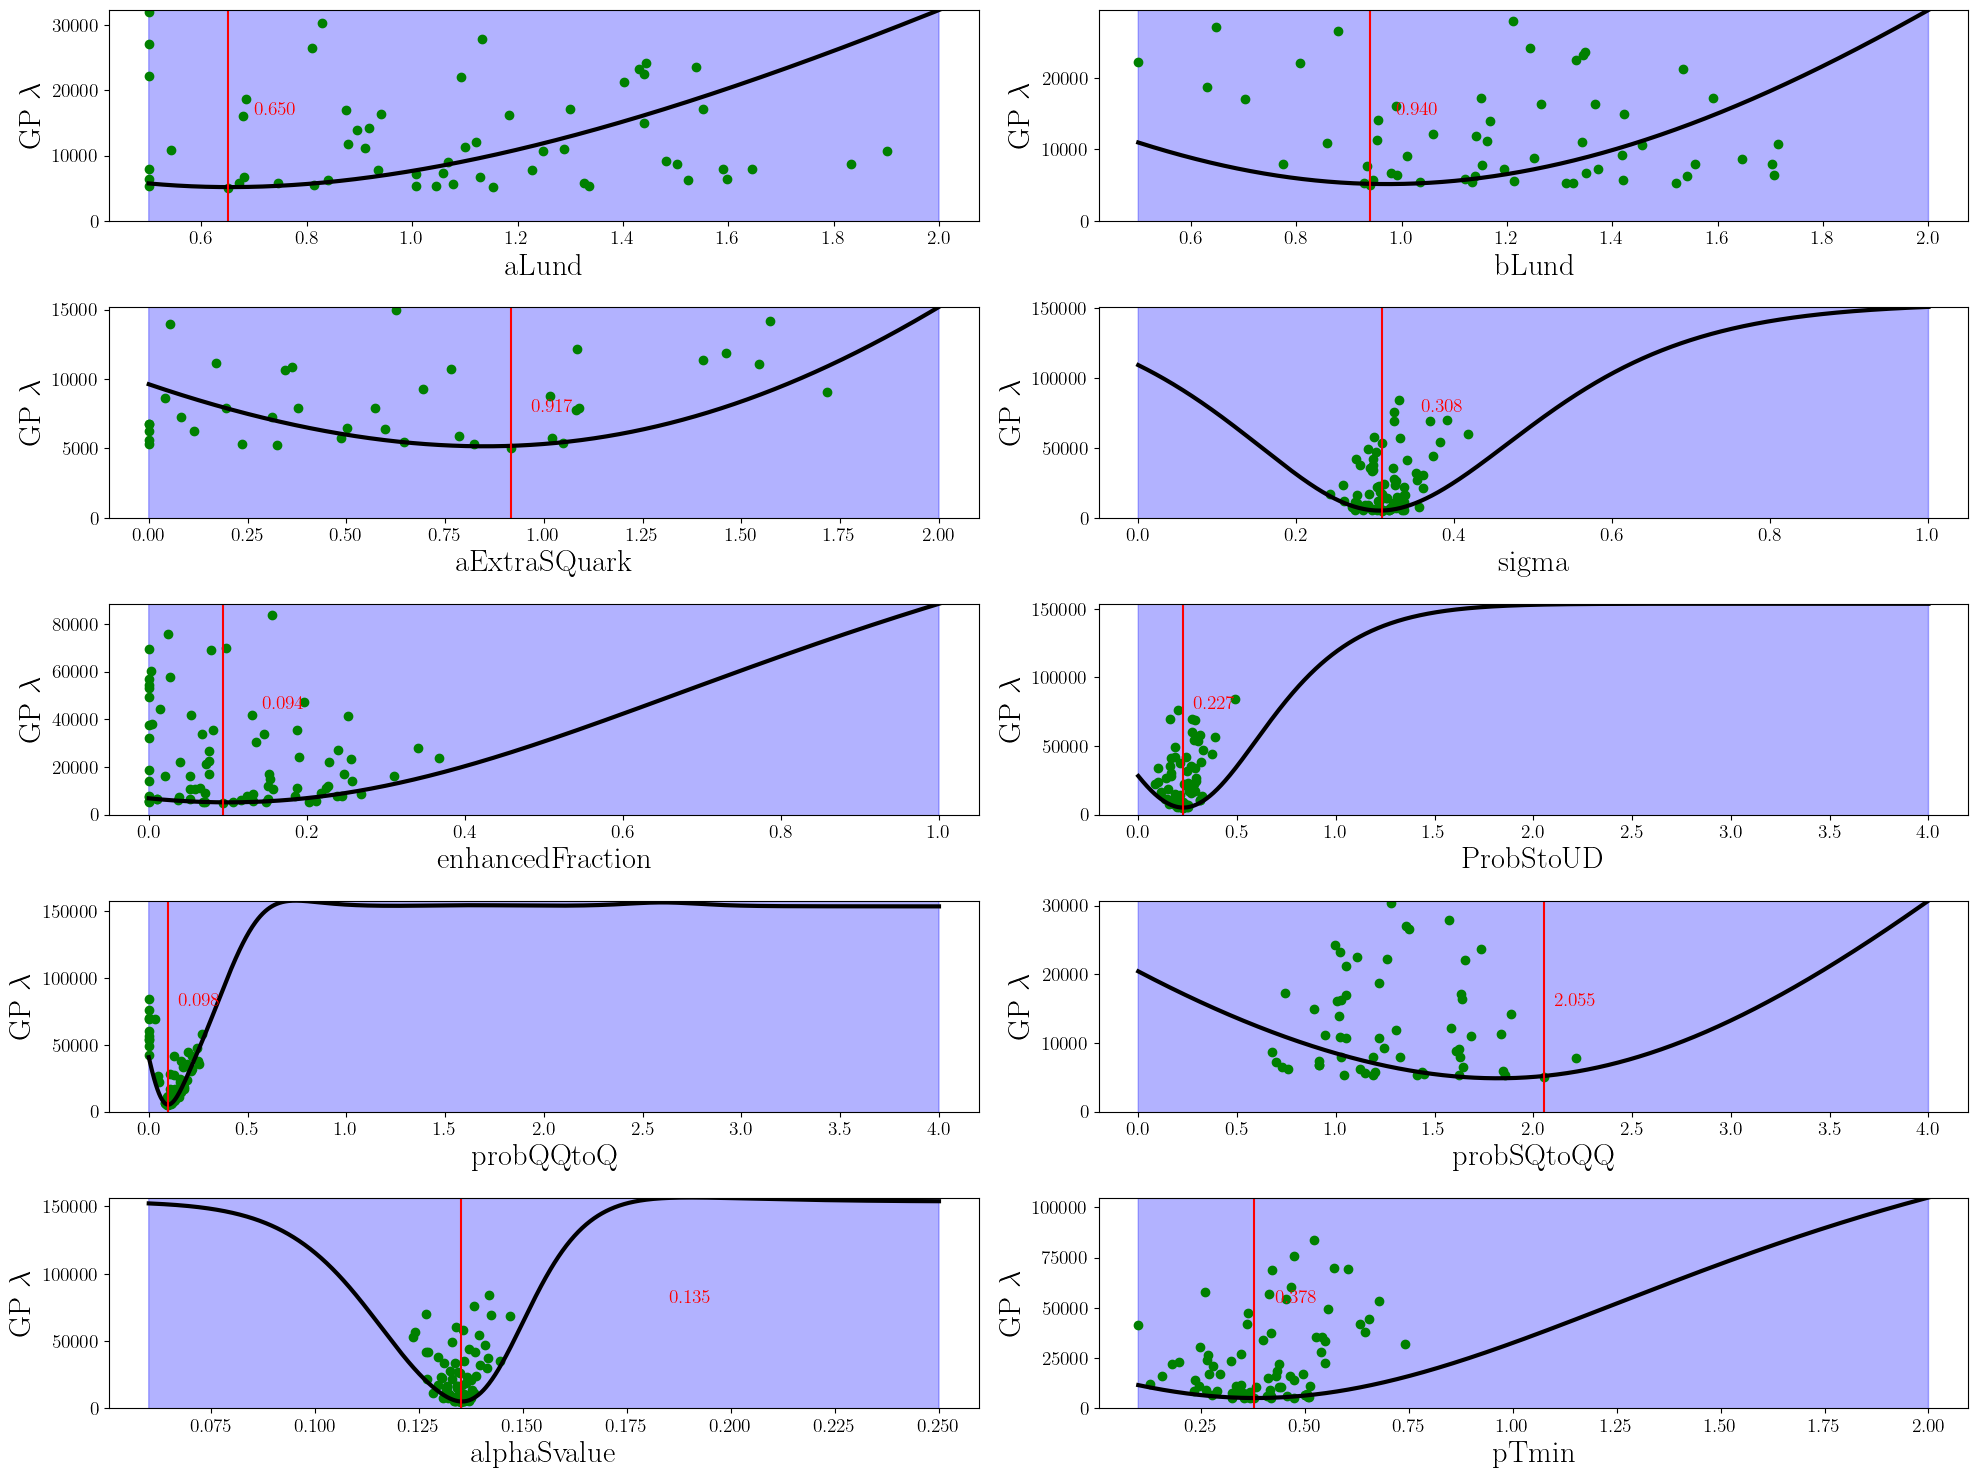

In [214]:
fig, ax = plt.subplots(5, 2, figsize=(20,15))
ax = ax.ravel()
for i, axi in enumerate(ax):
    params = list(REDUCED_MONASH_DICT.keys())
    plot_model_chi2_vs_param(param=params[i], reference_dict=best_parameters_reduced, ax=axi)

plt.tight_layout()
plt.savefig(f'images/GP_lambda_vs_param_all_params.pdf')

# Get profile likelihood of each parameter with Minuit, and the total covariance matrix

In [215]:
import iminuit
from iminuit import Minuit

In [216]:
def cost_func(aLund, 
             bLund,
            aExtraSQuark,
            sigma,
            enhancedFraction,
            ProbStoUD,
            probQQtoQ,
            probSQtoQQ,
            alphaSvalue,
            pTmin):
    
    params_dict = {
    "aLund" : aLund, 
    "bLund" : bLund,
    "aExtraSQuark": aExtraSQuark,
    "sigma":sigma,
    "enhancedFraction":enhancedFraction,
    "ProbStoUD":ProbStoUD,
    "probQQtoQ":probQQtoQ,
    "probSQtoQQ":probSQtoQQ,
    "alphaSvalue": alphaSvalue,
    "pTmin": pTmin
    }
    means, covs = model.predict([
            ObservationFeatures(parameters=params_dict)
        ]
    )
    return means['true_objective_func'][0]

In [251]:
# mean value func at BO point
cost_func(**best_parameters_reduced)

5184.530222962749

In [218]:
limits = list(PARAM_DICT.values())

In [219]:
m = Minuit(cost_func, **best_parameters_reduced)
m.limits = limits

In [220]:
m.migrad(ncall=500000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4532                       │              Nfcn = 366              │
│ EDM = 9.36e-06 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ aLund            │   0.578   │   0.011   │            │            │   0.5   │    2    │       │
│ 1 │ bLund            │   0.960   │   0.008   │            │            │   0.5   │    2    │       │
│ 2 │ aExtraSQuark     │   0.537   │   0.035   │            │            │    0    │    2    │       │
│ 3 │ sigma            │  0.3199   │  0.0016   │            │            │    0    │    1    │       │
│ 4 │ enhancedFraction │   0.036   │   0.007   │            │            │    0    │    1    │       │
│ 5 │ ProbStoUD        │  0.2330   │  0.0015   │            │            │    0    │    4    │       │
│ 6 │ probQQtoQ        │  96.8e-3  │  0.6e-3   │            │            │    0    │    4    │       │
│ 7 │ probSQtoQQ       │   1.594   │   0.030   │            │            │    0    │    4    │       │
│ 8 │ alphaSvalue      │ 136.22e-3 │  0.11e-3  │            │            │  0.06   │  0.25   │       │
│ 9 │ pTmin            │   0.430   │   0.006   │            │            │   0.1   │    2    │       │
└───┴──────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  │            aLund            bLund     aExtraSQuark            sigma enhancedFraction        ProbStoUD        probQQtoQ       probSQtoQQ      alphaSvalue            pTmin │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            aLund │         0.000123          0.06e-3          0.23e-3         -11.0e-6          0.05e-3          -4.2e-6          -1.9e-6          0.18e-3        -0.742e-6         -0.04e-3 │
│            bLund │          0.06e-3         7.07e-05          0.12e-3          -5.9e-6          0.03e-3          -1.9e-6          -1.5e-6          0.09e-3        -0.372e-6         -0.02e-3 │
│     aExtraSQuark │          0.23e-3          0.12e-3          0.00123         -49.8e-6          0.21e-3          -7.0e-6          -4.8e-6           0.9e-3        -2.929e-6         -0.17e-3 │
│            sigma │         -11.0e-6          -5.9e-6         -49.8e-6         2.61e-06          -9.6e-6           0.4e-6           0.3e-6         -41.0e-6         0.144e-6           7.7e-6 │
│ enhancedFraction │          0.05e-3          0.03e-3          0.21e-3          -9.6e-6          4.5e-05          -1.9e-6          -1.2e-6          0.17e-3        -0.585e-6         -0.03e-3 │
│        ProbStoUD │          -4.2e-6          -1.9e-6          -7.0e-6           0.4e-6          -1.9

In [221]:
best_parameters_reduced

{'aLund': 0.6500049858724484,
 'bLund': 0.9401929253219509,
 'aExtraSQuark': 0.9168928775652091,
 'sigma': 0.30812601635724085,
 'enhancedFraction': 0.09376606126317734,
 'ProbStoUD': 0.22732590820741946,
 'probQQtoQ': 0.09828054814612876,
 'probSQtoQQ': 2.0547395267064457,
 'alphaSvalue': 0.135045793331446,
 'pTmin': 0.3779248422937622}

In [222]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4532                       │             Nfcn = 2158              │
│ EDM = 9.36e-06 (Goal: 0.0002)    │            time = 1.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ aLund            │   0.578   │   0.011   │   -0.011   │   0.011    │   0.5   │    2    │       │
│ 1 │ bLund            │   0.960   │   0.008   │   -0.008   │   0.009    │   0.5   │    2    │       │
│ 2 │ aExtraSQuark     │   0.537   │   0.035   │   -0.034   │   0.035    │    0    │    2    │       │
│ 3 │ sigma            │  0.3199   │  0.0016   │  -0.0016   │   0.0016   │    0    │    1    │       │
│ 4 │ enhancedFraction │   0.036   │   0.007   │   -0.006   │   0.007    │    0    │    1    │       │
│ 5 │ ProbStoUD        │  0.2330   │  0.0015   │  -0.0015   │   0.0015   │    0    │    4    │       │
│ 6 │ probQQtoQ        │  96.8e-3  │  0.6e-3   │  -0.6e-3   │   0.6e-3   │    0    │    4    │       │
│ 7 │ probSQtoQQ       │   1.594   │   0.031   │   -0.030   │   0.030    │    0    │    4    │       │
│ 8 │ alphaSvalue      │ 136.22e-3 │  0.11e-3  │  -0.11e-3  │  0.11e-3   │  0.06   │  0.25   │       │
│ 9 │ pTmin            │   0.430   │   0.006   │   -0.006   │   0.006    │   0.1   │    2    │       │
└───┴──────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         aLund         │         bLund         │     aExtraSQuark      │         sigma         │   enhancedFraction    │       ProbStoUD       │       probQQtoQ       │      probSQtoQQ       │      alphaSvalue      │         pTmin         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.011   │   0.011   │  -0.008   │   0.009   │  -0.034   │   0.035   │  -0.0016  │  0.0016   │  -0.006   │   0.007   │  -0.0015  │  0.0015   │  -0.6e-3  │  0.6e-3   │   -0.03   │   0.03    │ -0.11e-3  │  0.11e-3  │  -0.006   │   0.006   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False

In [260]:
cost_func_at_BO = cost_func(**best_parameters_reduced)
print(f'cost function at BO point = {cost_func_at_BO}')
scale_vals = [1.05,1.1]
for scale in scale_vals:
    scaled_point_BO = {}
    for key, val in best_parameters_reduced.items():
        scaled_point_BO[key] = val * scale
    print()
    print(f'cost function at BO point scaled by {scale} = {cost_func(**scaled_point_BO)}')


cost function at BO point = 5184.530222962749

cost function at BO point scaled by 1.05 = 17634.119297232246

cost function at BO point scaled by 1.1 = 50598.71060815499


In [261]:
minos_points = m.values.to_dict()
minos_points

{'aLund': 0.5778117622792757,
 'bLund': 0.9600374450150893,
 'aExtraSQuark': 0.537231133686081,
 'sigma': 0.3199225654263836,
 'enhancedFraction': 0.03614626382569172,
 'ProbStoUD': 0.23304917378354353,
 'probQQtoQ': 0.09676983002509686,
 'probSQtoQQ': 1.5935087782247985,
 'alphaSvalue': 0.13622136230557338,
 'pTmin': 0.43017166568309007}

In [262]:
cost_func_at_minuit = cost_func(**minos_points)
print(f'cost function at Minuit point = {cost_func_at_minuit}')
scale_vals = [1.05,1.1]
for scale in scale_vals:
    scaled_point_minuit = {}
    for key, val in minos_points.items():
        scaled_point_minuit[key] = val * scale
    print()
    print(f'cost function at Minuit point scaled by {scale} = {cost_func(**scaled_point_minuit)}')


cost function at Minuit point = 4532.204663255259

cost function at Minuit point scaled by 1.05 = 18386.942152152253

cost function at Minuit point scaled by 1.1 = 54476.715480456645


Minos is deeper minimum than BO

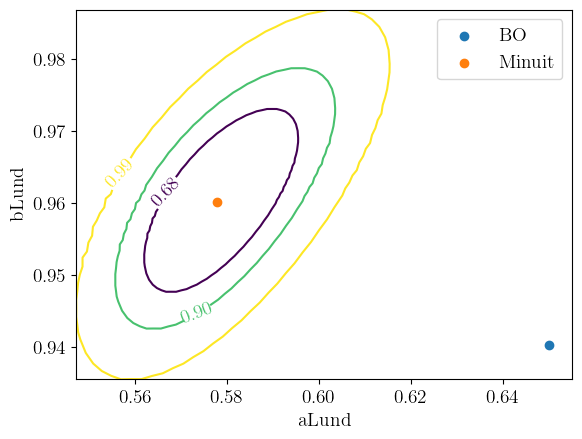

In [264]:
m.draw_mncontour('aLund','bLund', cl=(0.68, 0.9, 0.99))
plt.scatter(best_parameters_reduced['aLund'], best_parameters_reduced['bLund'], label='BO')
plt.scatter(m.values['aLund'], m.values['bLund'], label='Minuit')
plt.legend()

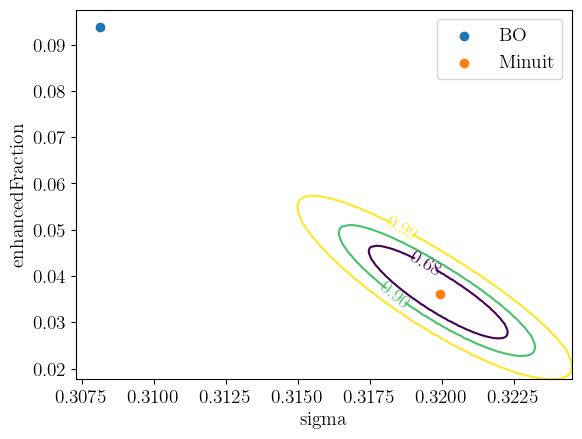

In [227]:
m.draw_mncontour('sigma','enhancedFraction', cl=(0.68, 0.9, 0.99))
plt.scatter(best_parameters_reduced['sigma'], best_parameters_reduced['enhancedFraction'], label='BO')
plt.scatter(m.values['sigma'], m.values['enhancedFraction'], label='Minuit')
plt.legend()

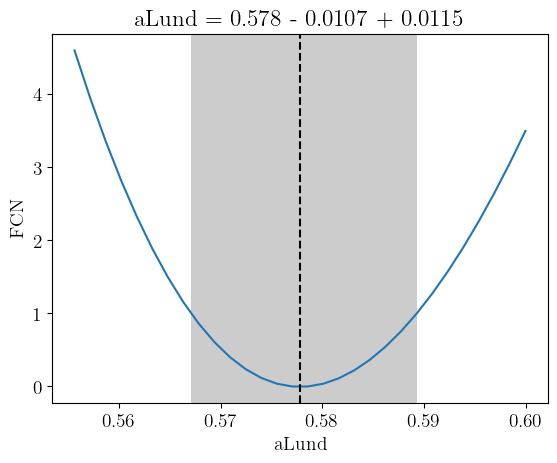

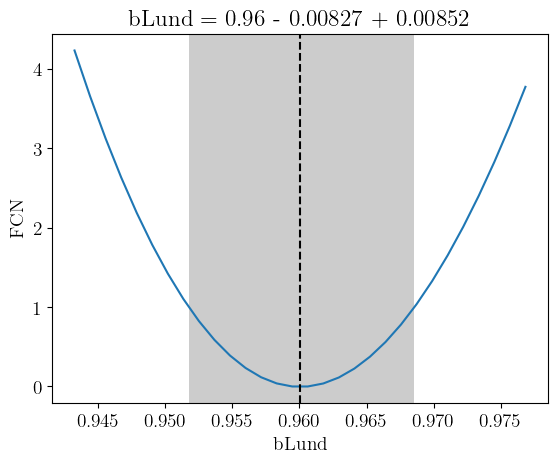

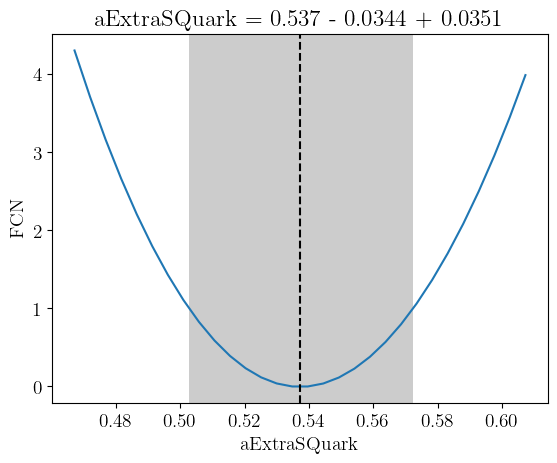

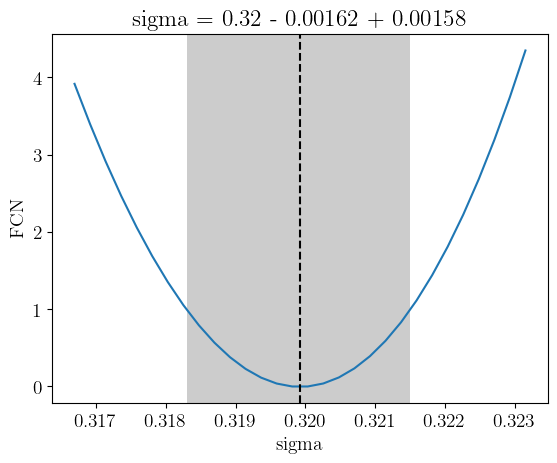

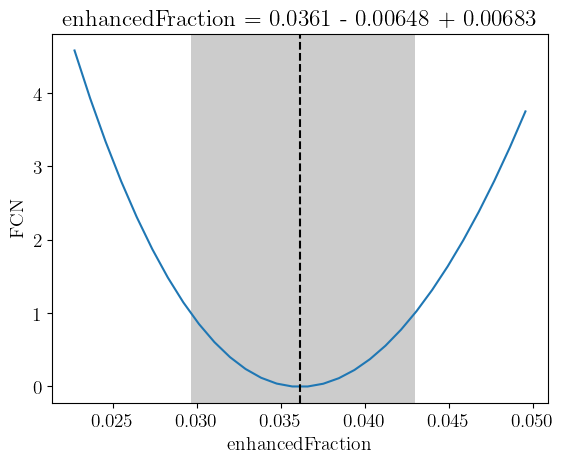

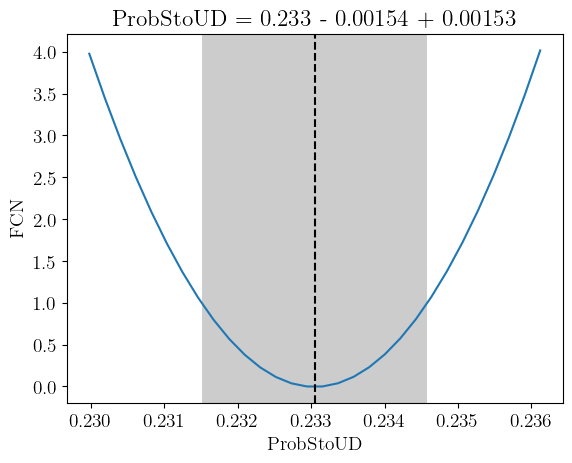

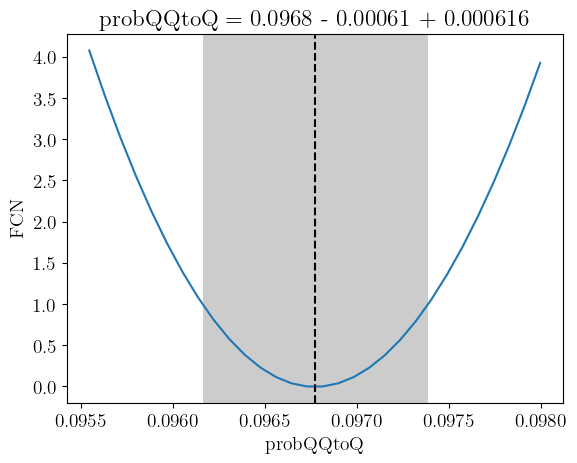

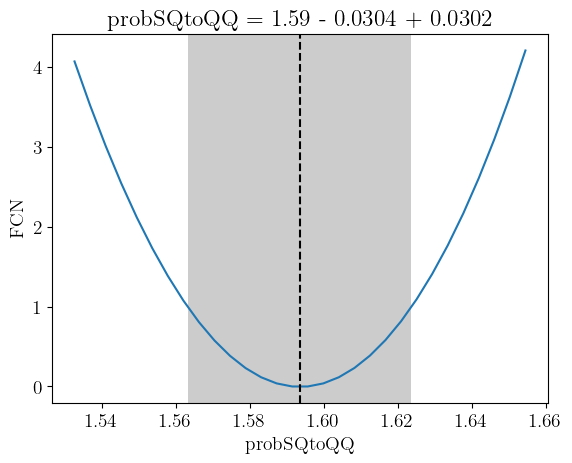

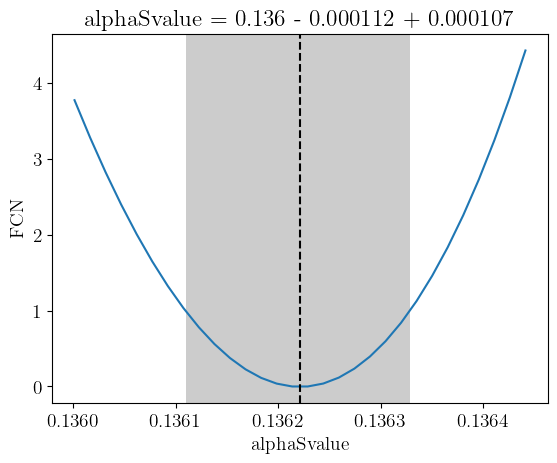

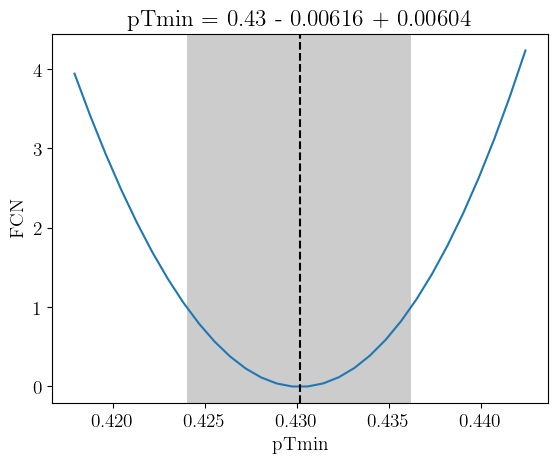

In [234]:
for param in params:
    plt.figure()
    m.draw_mnprofile(param)

In [229]:
covariance = m.covariance
covariance

┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  │            aLund            bLund     aExtraSQuark            sigma enhancedFraction        ProbStoUD        probQQtoQ       probSQtoQQ      alphaSvalue            pTmin │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            aLund │         0.000123          0.06e-3          0.23e-3         -11.0e-6          0.05e-3          -4.2e-6          -1.9e-6          0.18e-3        -0.742e-6         -0.04e-3 │
│            bLund │          0.06e-3         7.07e-05          0.12e-3          -5.9e-6          0.03e-3          -1.9e-6          -1.5e-6          0.09e-3        -0.372e-6         -0.02e-3 │
│     aExtraSQuark │          0.23e-3          0.12e-3          0.00123         -49.8e-6          0.21e-3          -7.0e-6          -4.8e-6           0.9e-3        -2.929e-6         -0.17e-3 │
│            sigma │         -11.0e-6          -5.9e-6         -49.8e-6         2.61e-06          -9.6e-6           0.4e-6           0.3e-6         -41.0e-6         0.144e-6           7.7e-6 │
│ enhancedFraction │          0.05e-3          0.03e-3          0.21e-3          -9.6e-6          4.5e-05          -1.9e-6          -1.2e-6          0.17e-3        -0.585e-6         -0.03e-3 │
│        ProbStoUD │          -4.2e-6          -1.9e-6          -7.0e-6           0.4e-6          -1.9e-6         2.36e-06          -0.1e-6          -6.4e-6         0.030e-6           1.2e-6 │
│        probQQtoQ │          -1.9e-6          -1.5e-6          -4.8e-6           0.3e-6          -1.2e-6          -0.1e-6         3.76e-07          -4.0e-6         0.027e-6           0.8e-6 │
│       probSQtoQQ │          0.18e-3          0.09e-3           0.9e-3         -41.0e-6          0.17e-3          -6.4e-6          -4.0e-6         0.000932        -2.483e-6         -0.14e-3 │
│      alphaSvalue │        -0.742e-6        -0.372e-6        -2.929e-6         0.144e-6        -0.585e-6         0.030e-6         0.027e-6        -2.483e-6         1.21e-08         0.457e-6 │
│            pTmin │         -0.04e-3         -0.02e-3         -0.17e-3           7.7e-6         -0.03e-3           1.2e-6           0.8e-6         -0.14e-3         0.457e-6         3.76e-05 │
└──────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [230]:
covariance.correlation()

┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  │            aLund            bLund     aExtraSQuark            sigma enhancedFraction        ProbStoUD        probQQtoQ       probSQtoQQ      alphaSvalue            pTmin │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            aLund │                1              0.7              0.6             -0.6              0.7             -0.2             -0.3              0.5             -0.6             -0.5 │
│            bLund │              0.7                1              0.4             -0.4              0.5             -0.1             -0.3              0.4             -0.4             -0.4 │
│     aExtraSQuark │              0.6              0.4                1             -0.9              0.9             -0.1             -0.2              0.9             -0.8             -0.8 │
│            sigma │             -0.6             -0.4             -0.9                1             -0.9              0.1              0.3             -0.8              0.8              0.8 │
│ enhancedFraction │              0.7              0.5              0.9             -0.9                1             -0.2             -0.3              0.8             -0.8             -0.8 │
│        ProbStoUD │             -0.2             -0.1             -0.1              0.1             -0.2                1             -0.1             -0.1              0.2              0.1 │
│        probQQtoQ │             -0.3             -0.3             -0.2              0.3             -0.3             -0.1                1             -0.2              0.4              0.2 │
│       probSQtoQQ │              0.5              0.4              0.9             -0.8              0.8             -0.1             -0.2                1             -0.7             -0.8 │
│      alphaSvalue │             -0.6             -0.4             -0.8              0.8             -0.8              0.2              0.4             -0.7                1              0.7 │
│            pTmin │             -0.5             -0.4             -0.8              0.8             -0.8              0.1              0.2             -0.8              0.7                1 │
└──────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

## Validate the results with the Minuit best fit point

In [265]:
run_valid_card(minos_points)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-06 21:29:01
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:02 elapsed)
Event 900 (0:00:02 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:03 elapsed)
Event 1600 (0:00:03 elapsed)
Event 1700 (0:00:03 elapsed)
Event 1800 (0:00:04 elapsed)
Event 1900 (0:00:04 elapsed)
Event 2000 (0:00:04 elapsed)
Event 2100 (0:00:04 elapsed)
Event 2200 (0:00:04 elapsed)
Event 2300 (0:00:04 elapsed)
Event 2400 (0:00:04 elapsed)
Event 2500 (0:00:05 elapsed)
Event 2600 (0:00:05 elapsed)
Event 2700 (0:00:05 elapsed)
Event 2800 (0:00:05 elapsed)
Event 2900 (0:00:05 elapsed)
Event 3000 (0





Rivet.AnalysisHandler: INFO  Using named weights


In [266]:
dfdata, dfsims_valid, generated_indices = get_valid_data()

[0, 0]
looping over 2 sim yoda files...



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1/2 [00:00<00:00,  6.79it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


In [267]:
print(generated_indices)
# print(dfsims)
print('DATA DATAFRAME')
print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
print('FIRST SIM-VALID DATAFRAME')
print(dfsims_valid[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

[0, 0]
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM-VALID DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.448800  0.009959  0.042464  0.031830     15561.0
1  0.005  0.010  23.898399  0.019119  0.178911  0.277557     29873.0
2  0.010  0.015  20.910400  0.016728  0.259191  0.651228     26138.0
3  0.015  0.020  17.056801  0.013645  0.296816  1.040128     21321.0
4  0.020  0.025  13.781600  0.011025  0.309051  1.391788     17227.0


In [268]:
data_keys, mc_keys = get_hist_names(dfdata)
filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims_valid, data_keys, mc_keys)

 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

In [269]:
reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)
print(reduced_data_keys, reduced_mc_keys)
print(f'length of reduced data keys = {len(reduced_data_keys)}')
print(f'length of reduced mc keys = {len(reduced_mc_keys)}')

['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S3486095/d37-x01-y01',

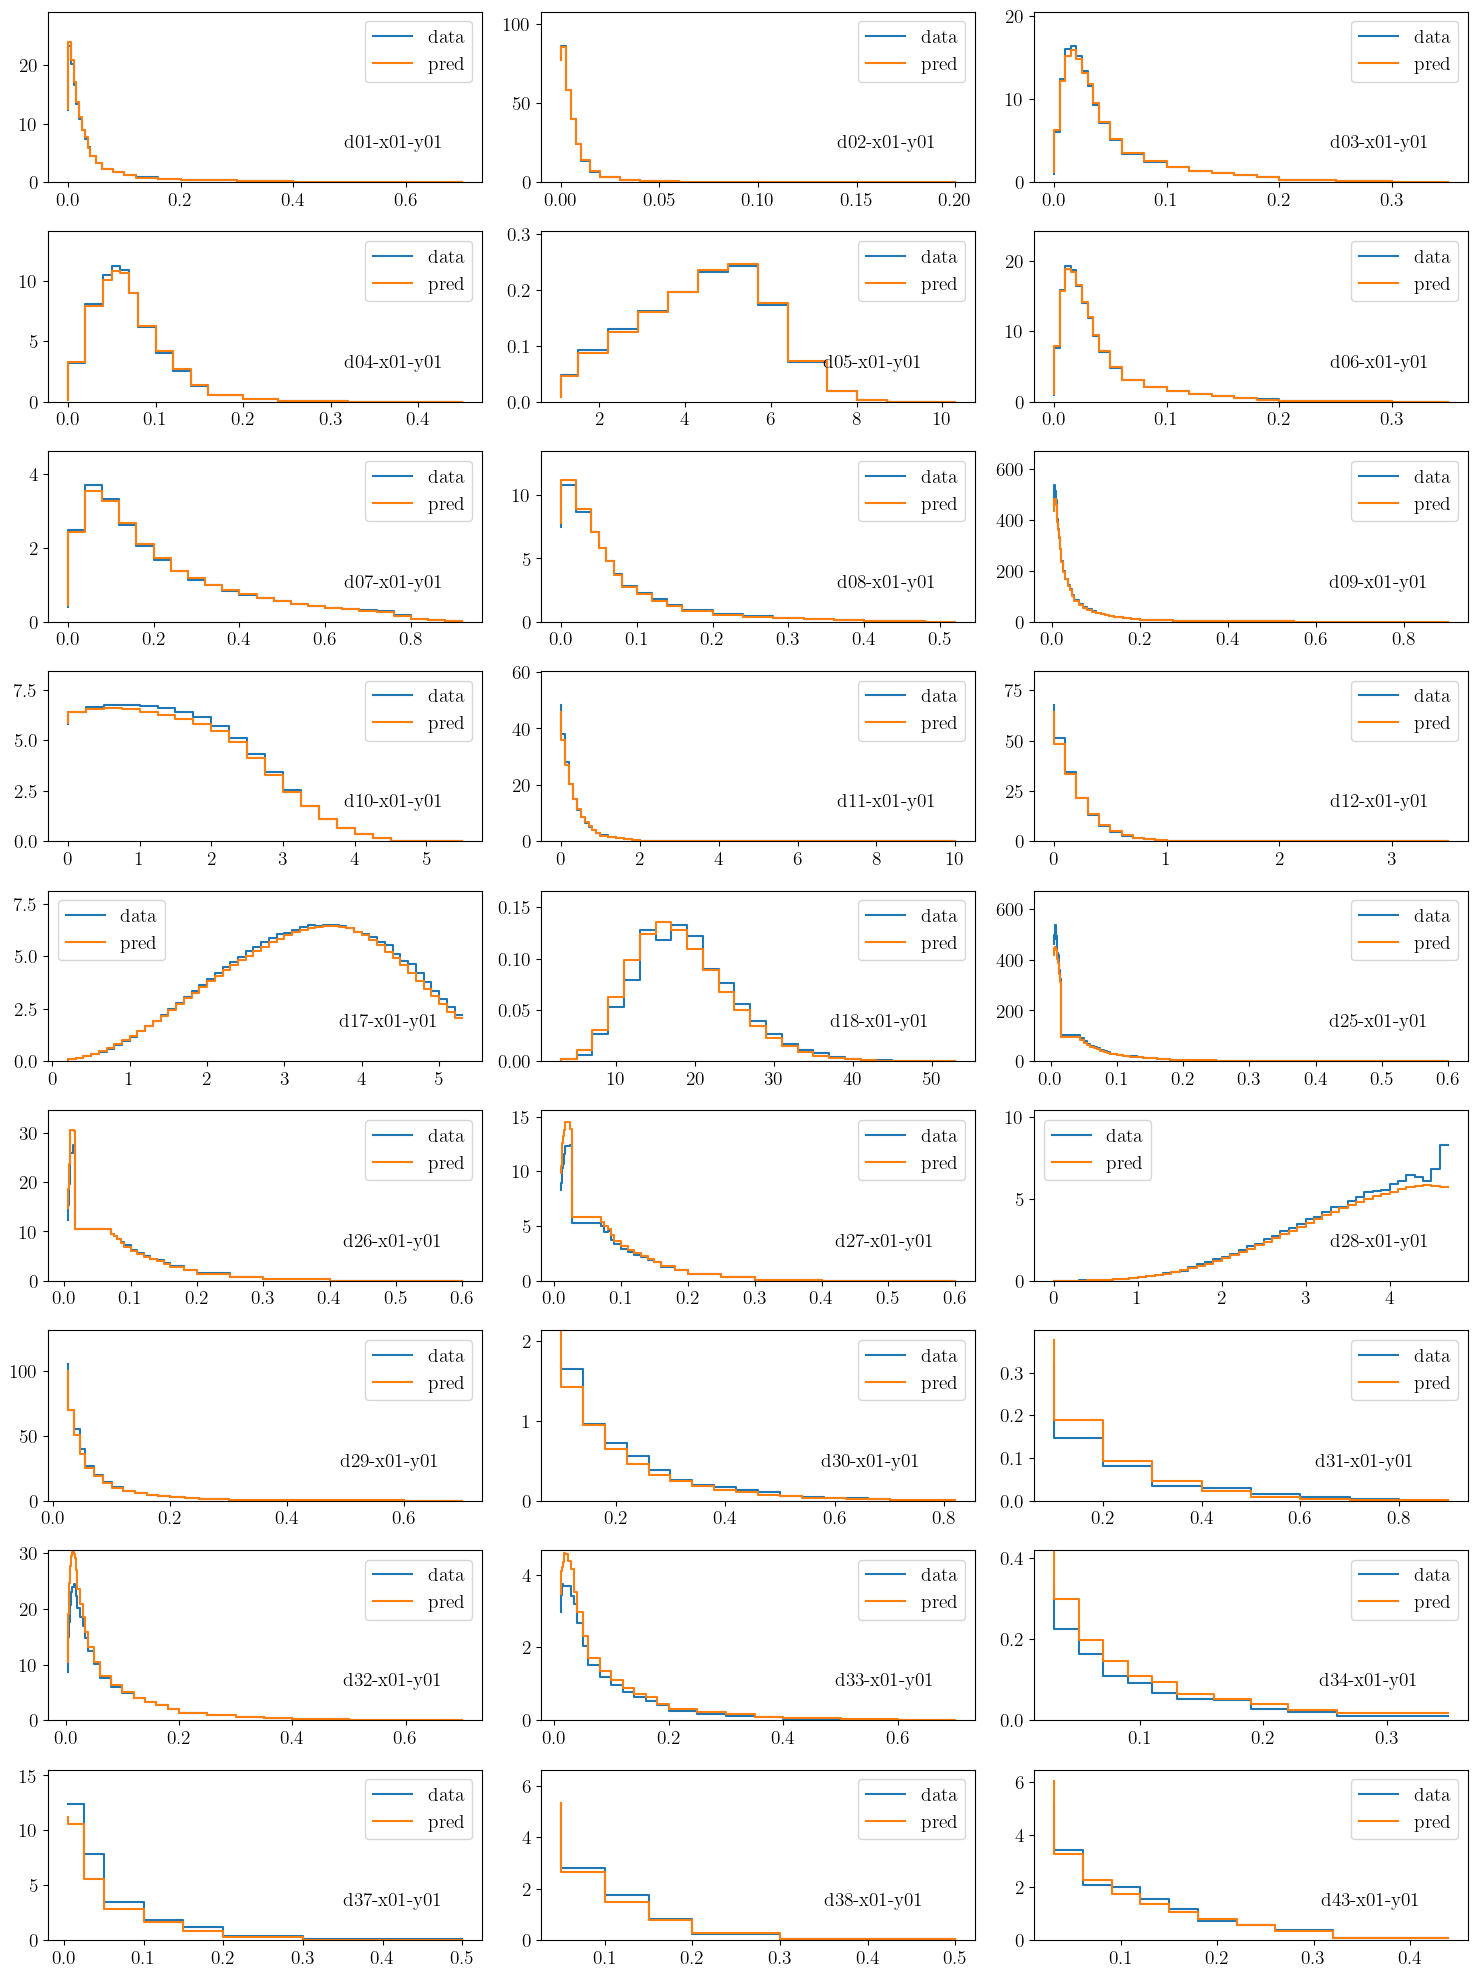

In [270]:
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import * 

hists = make_hists(dfdata, dfsims_valid[0], reduced_data_keys, reduced_mc_keys)

plot_dist(reduced_data_keys, hists, filename=f'images/Ax_Minuit_Valid_Best_fit_hists_reduced_params_{N_ITER}_iter.pdf')

In [285]:
import emcee

In [288]:
REDUCED_MONASH_DICT

{'aLund': 0.68,
 'bLund': 0.98,
 'aExtraSQuark': 0.0,
 'sigma': 0.335,
 'enhancedFraction': 0.01,
 'ProbStoUD': 0.217,
 'probQQtoQ': 0.081,
 'probSQtoQQ': 0.915,
 'alphaSvalue': 0.1365,
 'pTmin': 0.5}

In [302]:
Monash_init_points = np.array(list(REDUCED_MONASH_DICT.values()))
Monash_init_points= Monash_init_points.reshape(1,10)
Monash_init_points.shape

(1, 10)

In [301]:
minos_points

{'aLund': 0.5778117622792757,
 'bLund': 0.9600374450150893,
 'aExtraSQuark': 0.537231133686081,
 'sigma': 0.3199225654263836,
 'enhancedFraction': 0.03614626382569172,
 'ProbStoUD': 0.23304917378354353,
 'probQQtoQ': 0.09676983002509686,
 'probSQtoQQ': 1.5935087782247985,
 'alphaSvalue': 0.13622136230557338,
 'pTmin': 0.43017166568309007}

In [303]:
minos_init_points = np.array(list(REDUCED_MONASH_DICT.values()))
minos_init_points= minos_init_points.reshape(1,10)
minos_init_points.shape

(1, 10)

In [305]:
init_points = np.concatenate([Monash_init_points,minos_init_points])
init_points.shape

(2, 10)

In [357]:
def cost_func_emcee(params):
    aLund, bLund, aExtraSQuark, sigma,enhancedFraction,ProbStoUD,probQQtoQ,probSQtoQQ,alphaSvalue,pTmin = params
    
    params_dict = {
    "aLund" : aLund, 
    "bLund" : bLund,
    "aExtraSQuark": aExtraSQuark,
    "sigma":sigma,
    "enhancedFraction":enhancedFraction,
    "ProbStoUD":ProbStoUD,
    "probQQtoQ":probQQtoQ,
    "probSQtoQQ":probSQtoQQ,
    "alphaSvalue": alphaSvalue,
    "pTmin": pTmin
    }
    means, covs = model.predict([
            ObservationFeatures(parameters=params_dict)
        ]
    )
    
    result=means['true_objective_func'][0]
    if np.isnan(result):
        result = -np.inf
    
    return result


ndim=10
nwalkers = 21 #has to be even, preferabbly a multiple of n_params
nparams=10
n_burn    = 500 # "burn-in" period to let chains stabilize
n_steps = 50000   # number of MCMC steps to take after burn-in


filename = 'EMCEE_SAMPLER.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
p0 = np.random.randn(nwalkers, ndim)

#you can access the sampler later (to check convergence, etc) by sampler = emcee.backends.HDFBackend(filename)
#Start the sampler. first arg=number of walkers, second: number of parameters, third the log likelihood, threads gives you th eoption to use more cores
sampler = emcee.EnsembleSampler(nwalkers, nparams, cost_func_emcee, backend = backend, threads=12)

#DO THE BIRN IN, RUN MCMC WITHOUT STORING THE RESULTS
pos, prob, state = sampler.run_mcmc(p0, n_burn, progress=True, store=True)
sampler.reset()

# Sample again, starting from end burn-in state (starting at pos and ending at nsteops)

state = sampler.run_mcmc(p0,n_steps, progress=True, store=True)

##########GET THE ACTUAL SAMPLES. Samples will have shape (n_walkers, n_params), eg. samples[:,0] is the density of the first parameter
samples = sampler.get_chain(flat=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [38:28<00:00, 21.66it/s]


In [358]:
samples.shape

(1050000, 10)

(array([  1604.,  23474.,  76945., 153414., 388389., 200972., 128788.,
         58338.,  17043.,   1033.]),
 array([-1.88561013e+154, -1.49492906e+154, -1.10424800e+154,
        -7.13566936e+153, -3.22885872e+153,  6.77951918e+152,
         4.58476255e+153,  8.49157319e+153,  1.23983838e+154,
         1.63051945e+154,  2.02120051e+154]),
 <BarContainer object of 10 artists>)

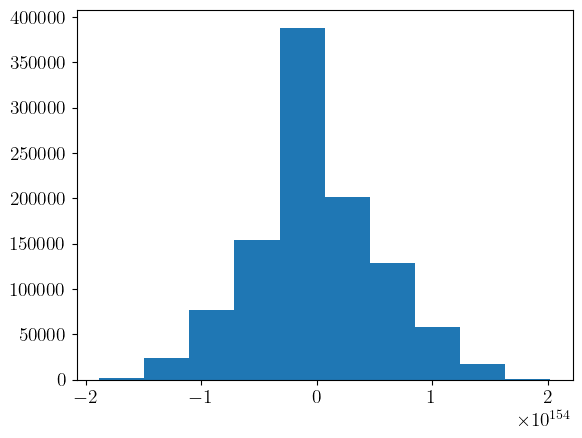

In [359]:
plt.hist(samples[:,0])

(array([  2160.,  20968.,  63290., 126149., 210493., 409447., 127348.,
         65753.,  21571.,   2821.]),
 array([-1.75950147e+154, -1.41072542e+154, -1.06194936e+154,
        -7.13173307e+153, -3.64397252e+153, -1.56211959e+152,
         3.33154860e+153,  6.81930916e+153,  1.03070697e+154,
         1.37948303e+154,  1.72825908e+154]),
 <BarContainer object of 10 artists>)

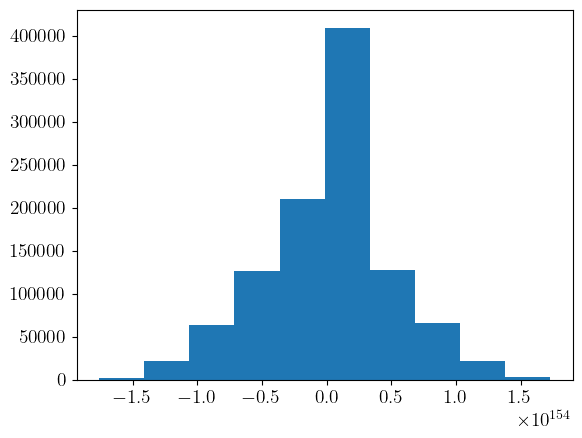

In [360]:
plt.hist(samples[:,1])